# Proyecto OCR

#
**Librerias**

In [1]:
import fitz
from PIL import Image
import requests
from flask import Flask, request
from io import BytesIO
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
import pyodbc
print(pyodbc.drivers())
from transformers import pipeline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

['SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)', 'SQL Server Native Client RDA 11.0', 'ODBC Driver 17 for SQL Server']


#
**Extraer textos de PDFs**

In [4]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

pdf_text = extract_text_from_pdf(r"C:\Proyecto_Doc_Finder\Doc-Finder\.vs\Doc-Finder\Base de datos\cedula 1.jpeg")
print(pdf_text)

#
**Extraer datos de imagenes**

**Imagen de ejemplo**

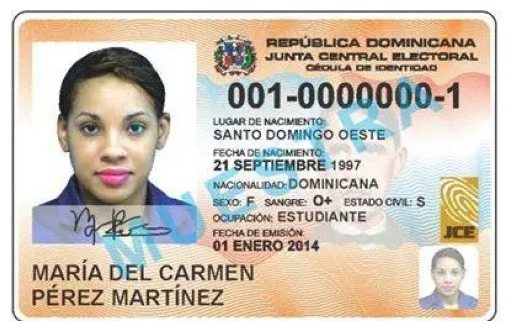

In [6]:
image_2_show = mpimg.imread(r"C:\Proyecto_Doc_Finder\Doc-Finder\.vs\Doc-Finder\Base de datos\cedula 1.jpeg")
plt.imshow(image_2_show)
plt.axis('off')
plt.show()

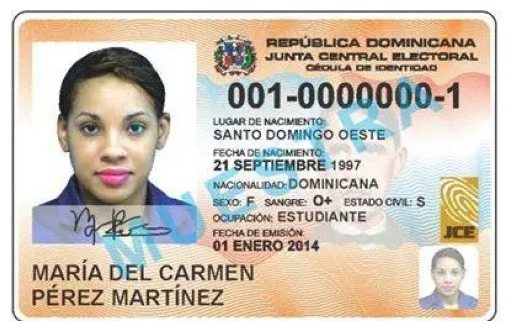

In [7]:
image_2_show = mpimg.imread(r"C:\Proyecto_Doc_Finder\Doc-Finder\.vs\Doc-Finder\Base de datos\cedula 1.jpeg")
plt.imshow(image_2_show)
plt.axis('off')
plt.show()

In [9]:
def extract_text_from_image(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image)
    return text

image_text = extract_text_from_image(r"C:\Proyecto_Doc_Finder\Doc-Finder\.vs\Doc-Finder\Base de datos\cedula 1.jpeg")
print(f"La imagen dice: {image_text}")

TesseractNotFoundError: C:\Program Files\Tesseract-OCR\tesseract.exe is not installed or it's not in your PATH. See README file for more information.

#
**Uso de GPU/CPU**

In [8]:
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

Using device: CPU


#
**Modelo de Zero Shot Image Classification - Facebook**

**Imagen de acuerdo de pago**

In [ ]:
image_2_show_2 = mpimg.imread(r"C:\Users\oswal\Pictures\Screenshots\Imagen_de_acuerdo_legal.png")
plt.imshow(image_2_show_2)
plt.axis('off')
plt.show()

#
**Ejemplos de funcionalidad**

In [9]:
def clasificar_imagen_zero_shot(ruta_imagen, etiquetas=None):
    if etiquetas is None:
        etiquetas = [
            "Contrato",
            "Factura",
            "Recibo",
            "Identificación personal",
            "Informe",
            "Currículum / Hoja de vida",
            "Certificado",
            "Licencia o permiso",
            "Correspondencia (cartas, emails)",
            "Documentación legal",
            "Documentación técnica",
            "Manual o guía",
            "Proyecto",
            "Planificación / Agenda",
            "Otros"
        ]

    classifier = pipeline("zero-shot-image-classification", model="facebook/metaclip-b16-fullcc2.5b")
    imagen = Image.open(ruta_imagen)
    resultado = classifier(imagen, candidate_labels=etiquetas)
    return resultado

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\Imagen_de_acuerdo_legal.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\acta.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\asamblea.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\certificado.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

In [ ]:
ruta = r"C:\Users\oswal\Pictures\Screenshots\onapi.png"
resultado = clasificar_imagen_zero_shot(ruta)
print(resultado)

**Función de clasificar documentos**

In [ ]:
def classify_document(text, categories):
    """
    Clasifica el texto de un documento en una categoría usando clasificación zero-shot.
    
    Args:
        text (str): Texto del documento a clasificar.
        categories (list): Lista de categorías posibles.
    
    Returns:
        str: Categoría predicha para el documento.
    """

    result = classifier(text, candidate_labels=categories)
    return result["labels"][0]

In [ ]:
import os

def obtener_archivos_carpeta(carpeta):
    archivos = []
    for nombre in os.listdir(carpeta):
        ruta_completa = os.path.join(carpeta, nombre)
        if os.path.isfile(ruta_completa):  # solo archivos, no subcarpetas
            archivos.append(ruta_completa)
    return archivos

In [ ]:
import os
import requests
import json

DEEPSEEK_API_KEY = "<API_KEY>"  # ⚠️ luego te digo algo importante de esto

def obtener_archivos_carpeta(carpeta):
    archivos = []
    for nombre in os.listdir(carpeta):
        ruta_completa = os.path.join(carpeta, nombre)
        if os.path.isfile(ruta_completa):
            archivos.append(ruta_completa)
    return archivos

def buscar_documentos_inteligente(consulta, carpeta_docs):
    file_paths = obtener_archivos_carpeta(carpeta_docs)

    if not file_paths:
        return "No se encontraron archivos en la carpeta."

    lista_archivos = "\n".join(
        f"- {os.path.basename(p)} ({p})" for p in file_paths
    )

    prompt = f"""
Tienes esta lista de documentos guardados en la carpeta:

{lista_archivos}

Tarea del usuario: {consulta}

1. Indica qué archivos parecen más relevantes y por qué.
2. Ten en cuenta el tipo de archivo según su extensión.
3. Devuelve la respuesta en formato de lista clara.
"""

    url = "https://api.deepseek.com/chat/completions"

    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "deepseek-chat",
        "messages": [
            {"role": "system", "content": "Eres un asistente que ayuda a elegir documentos relevantes."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.3
    }

    response = requests.post(url, headers=headers, json=payload)

    if response.status_code != 200:
        return f"Error API: {response.text}"

    data = response.json()
    return data["choices"][0]["message"]["content"]

def mostrar_resultados(texto):
    print("=== RESULTADOS ===")
    print(texto)

# ⚠️ RUTA CORREGIDA
carpeta_docs = r"C:\Proyecto_Doc_Finder\Doc-Finder\.vs\Doc-Finder\Base de datos"

resultados = buscar_documentos_inteligente(
    "Busca documentos relevantes del 2025",
    carpeta_docs
)

mostrar_resultados(resultados)

=== RESULTADOS ===
Error API: {"error":{"message":"Insufficient Balance","type":"unknown_error","param":null,"code":"invalid_request_error"}}
